# Extract feature from image

In [1]:
image_path = "images/elephant-12.gif"

In [2]:
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms.functional import gaussian_blur

# Load image
with Image.open(image_path) as img:
    image = np.array(img, dtype=np.uint8) # Get grayscale from binary

# Morphologically open image
kernel = np.ones((5, 5), np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)

image = image.astype(bool) # Convert to binary
image = Image.fromarray(image) # Convert to PIL object

# Resize to 224 x 224
image = image.resize((224, 224), resample=Image.Resampling.LANCZOS)

# Convert to RGB for input into CNN
image = image.convert('RGB')

# Add gaussian blur
image = gaussian_blur(image, (13, 13))

image = np.array(image) # Convert back to numpy array

# Convert to tensor and normalize according to mean and standard deviation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.8, 0.9, 0.9), (0.58, 0.5, 0.5))
])

In [3]:
import torch
from torchvision.models import mobilenet_v3_small

model = mobilenet_v3_small(weights="DEFAULT")
model.classifier = torch.nn.Identity() # model.classifier[:1] # torch.nn.Identity()
model.eval()
model = torch.jit.script(model) # JIT optimize model
model = torch.jit.optimize_for_inference(model) # Fuse batch norm + cnn layers

In [4]:
with torch.inference_mode():
    # Tensorize, normalize and add batch dimension
    image = transform(image)
    image = image.unsqueeze(0)

    # Extract features
    feature = model(image)

    # Remove batch dimension and convert features to numpy array
    feature = feature.squeeze(0)
    feature = feature.detach().cpu().numpy()

out_feature = feature

# Retrieve similar images

In [5]:
import pickle

# Load features of images in database
with open("features.pickle", 'rb') as file:
    features = pickle.load(file)

# Calculate Euclidean difference between input feature and features in database
dist_index = []
for filename, feature in features.items():
    dist = np.linalg.norm(out_feature-feature)
    dist_index.append({'filename': filename, 'distance': dist})
    
# Sort by distance in ascending order
dist_index = sorted(dist_index, key = lambda x: x['distance'])

# Print list of top 20 similar images
for dist in dist_index[0: 20]:
    distance = dist['distance']
    filename = dist['filename']
    print(f"{distance:.3f}\t{filename}")

0.000	elephant-12.gif
5.826	elephant-2.gif
5.829	elephant-15.gif
5.930	elephant-6.gif
6.093	elephant-3.gif
6.127	elephant-1.gif
6.415	elephant-5.gif
6.423	elephant-14.gif
6.656	elephant-20.gif
6.657	elephant-10.gif
6.683	elephant-13.gif
6.810	elephant-18.gif
6.980	elephant-16.gif
7.127	camel-20.gif
7.217	elephant-8.gif
7.383	elephant-19.gif
7.428	elephant-4.gif
7.533	elephant-7.gif
7.545	camel-1.gif
7.571	camel-12.gif


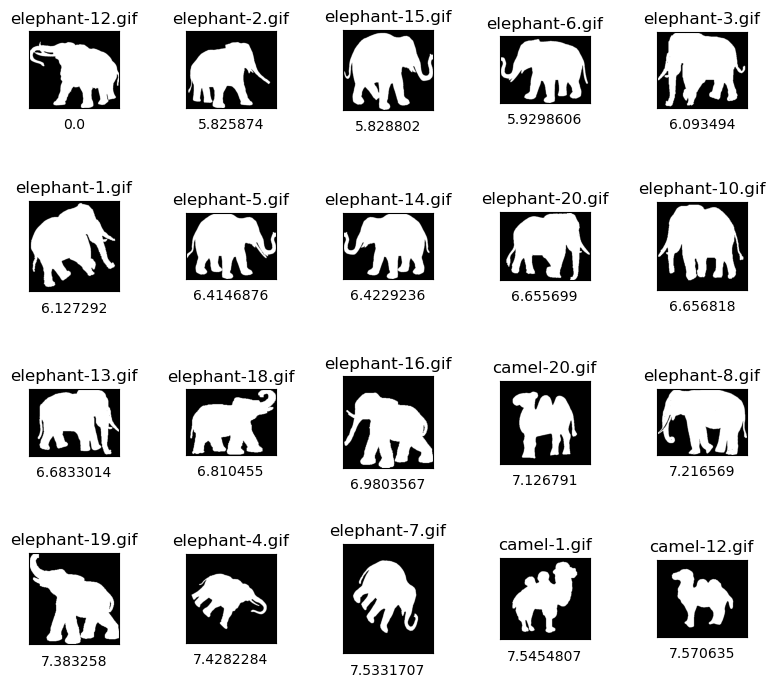

In [6]:
from utils import image_show

filenames = [dist['filename'] for dist in dist_index]
distances = [dist['distance'] for dist in dist_index]
images = []

for dist in dist_index[0: 20]:
    with Image.open(f"images/{dist['filename']}") as img:
        img = np.array(img, dtype=bool)
        images.append(img)
        
image_show(images, titles=filenames, labels=distances)

# Evaluate

In [7]:
import os

# Obtain class string from image path
img_class = os.path.split(image_path)[1].split('-')[0]

# Obtain class string from retrieved images' filename
ret_classes = [dist['filename'].split('-')[0] for dist in dist_index[:20]]

# Number of images that should be retrieved and was
tp = sum([img_class == ret_class for ret_class in ret_classes])

# Number of images that shouldn't be retrieved but was
fp = len(ret_classes) - tp

# Number of images that should be retrieved but wasn't
fn = sum([True for fn in features.keys() if img_class in fn]) - tp

# Number of images that shouldn't be retrieved and wasn't
tn = sum([True for fn in features.keys() if img_class not in fn]) - fp

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [8]:
print(f"TP: {tp}\tFP: {fp}\nFN: {fn}\tTN: {tn}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

TP: 17	FP: 3
FN: 3	TN: 377
Precision: 0.85
Recall: 0.85


# Plot Precision-Recall curve for current retrieval

Relevant class indexes:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 24, 28, 64]
Number of relevant images:  20
Precision:  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.93333333 0.9375     0.94117647 0.94444444 0.75
 0.67857143 0.3125    ]
Recall:  [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


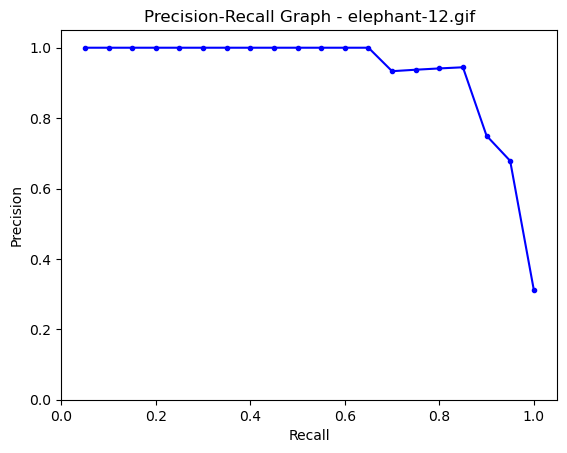

In [11]:
import matplotlib.pyplot as plt

# Refer to this stackoverflow answer regarding plotting Precision-Recall curve for CBIR
# https://stackoverflow.com/questions/25799107/how-do-i-plot-precision-recall-graphs-for-content-based-image-retrieval-in-matla

# Obtains what class the image is
img_class = os.path.split(image_path)[1].split('-')[0]

# Makes a list of sorted distances for all 400 images in database
distance_list = [dist['distance'] for dist in dist_index]

# A list of indexes of where the image class is located in distance_list
relevant_indexes = [i+1 for i, dist in enumerate(dist_index) if img_class in dist['filename']]
print("Relevant class indexes: ", relevant_indexes)
print("Number of relevant images: ", len(relevant_indexes))

# [1, 2, 3, 4, 5, ..., N] where N is the total num of relevant image class in database
thresholds = list(range(1, len(relevant_indexes)+1))

# Gets precision value if for every x number of images of relevant class are retrieved
# Precision = <relevant images retrieved> / (<relevant images retrieved> + <irrelevant images retrieved>)
precision = np.array(thresholds) / np.array(relevant_indexes)

# Creates multiple recall thresholds for x-axis where for x num of images retrieved, with y recall, what is the precision
# Recaall = <relevant images retrieved> / <relevant images in database>
recall = np.array(thresholds) / len(thresholds)

print("Precision: ", precision)
print("Recall: ", recall)

plt.plot(recall, precision, 'b.-')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Precision-Recall Graph - {os.path.split(image_path)[1]}')
plt.axis([0, 1.05, 0, 1.05]) # Set x-axis and y-axis range
plt.show()